Plot an ellipsoid

In [749]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
from matplotlib.patches import FancyArrowPatch, Patch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
from sofia_redux.toolkit.resampling.resample_utils import (
    coordinate_covariance, distribution_variances)
from sofia_redux.toolkit.resampling.resample import Resample

%matplotlib inline

In [30]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Plot showing resampling window

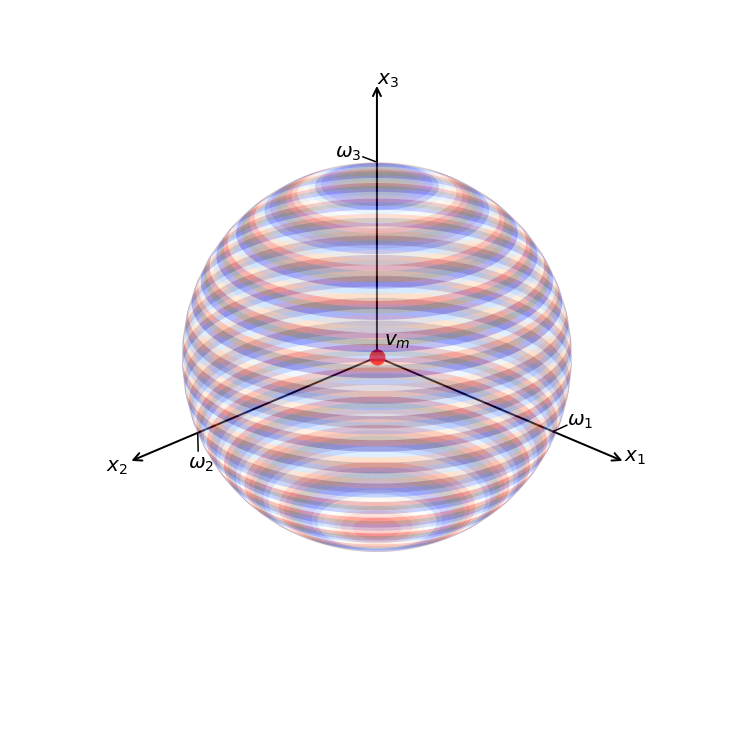

In [31]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

coefs = (1, 1, 1)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
# Radii corresponding to the coefficients:
rx, ry, rz = 1/np.sqrt(coefs)

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=1, cstride=1, cmap=cm.flag,
                shade=True, linewidth=5, alpha=0.25)

# Adjustment of the axes, so that they all have the same span:
max_radius = max(rx, ry, rz)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

l = 1 / np.sqrt(2)
w1 = Arrow3D([0, 1.7], [0, 0], [0, 0], mutation_scale=20, lw=2, arrowstyle="->", color="black")
w2 = Arrow3D([0, 0], [0, -1.7], [0, 0], mutation_scale=20, lw=2, arrowstyle="->", color="black")
w3 = Arrow3D([0, 0], [0, 0], [0, 1.5], mutation_scale=20, lw=2, arrowstyle="->", color="black")
ax.add_artist(w1)
ax.add_artist(w2)
ax.add_artist(w3)
ax.axis('off')
ax.view_init(25, -45)

ax.text(1.7, 0, 0, r"$x_{1}$", color='black', size=20)
ax.text(0, -1.85, 0, r"$x_{2}$", color='black', size=20)
ax.text(0, 0, 1.5, r"$x_{3}$", color='black', size=20)
ax.plot([1.23, 1.23], [0, 0.1], zs=[0, 0], color='black')
ax.plot([0, 0], [-1.25, -1.25], zs=[0, -0.1], color='black')
ax.plot([0, -0.1], [0, 0], zs=[1.08, 1.08], color='black')
ax.text(1.23, 0.1, 0, r"$\omega_{1}$", color='black', size=20)
ax.text(0, -1.32, -0.17, r"$\omega_{2}$", color='black', size=20)
ax.text(-0.3, 0, 1.02, r"$\omega_{3}$", color='black', size=20)

ax.plot([0], [0], zs=[0], marker='o', color='red', linewidth=100, markersize=15)
ax.text(0, 0.05, 0.05, r"$v_m$", color='black', size=20)

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/window.png',
            bbox_inches='tight', pad_inches=0)
plt.show()

Block searching

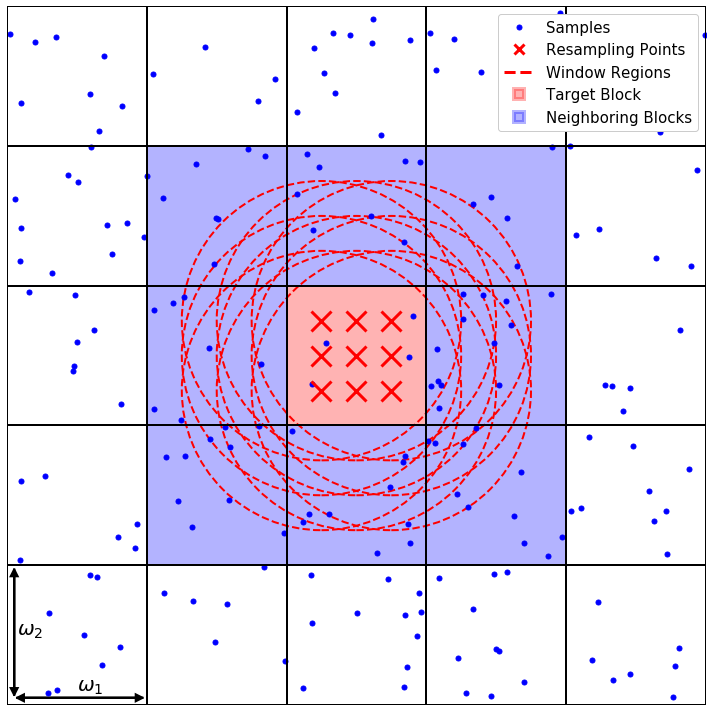

In [145]:
blocks = np.full((5, 5), np.nan)
blocks[1:4, 1:4] = 1
blocks[2, 2] = 2
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 10))
my_cmap = colors.ListedColormap(['b', 'g', 'r'])
my_cmap.set_bad(color='w', alpha=0)
for x in range(6):
    ax.axhline(x, lw=2, color='k', zorder=5)
    ax.axvline(x, lw=2, color='k', zorder=5)
ax.imshow(blocks, interpolation='none', cmap=my_cmap, extent=[0, 5, 0, 5], zorder=0, alpha=0.3)
# turn off the axis labels
ax.axis('off')


rand = np.random.RandomState(0)
samples = rand.random((2, 200)) * 5
plt.plot(*samples, '.', color='b', markersize=10)

circles = []
my_colors = ['r', 'k', 'm']

points = ((np.stack([x.ravel() for x in np.mgrid[:3, :3]]) + 1) / 4 + 2).T
for i, point in enumerate(points):
    ax.plot(*point, 'x', color='r', markersize=20, markeredgewidth=3)
    circles.append(plt.Circle((point[0], point[1]), radius=1, color='r', fill=False, linestyle='--', lw=2))
    ax.add_patch(circles[i])

    
    
legend_elements = [
    Line2D([0], [0], color='b', marker='.', markersize=10, lw=0, label='Samples'),
    Line2D([0], [0], color='r', marker='x', markersize=10, lw=0, markeredgewidth=3, label='Resampling Points'),
    Line2D([0], [0], color='r', lw=3, linestyle='--', label='Window Regions'),
    Line2D([0], [0], color='r', marker='s', markersize=10, lw=0, markeredgewidth=4, alpha=0.3, label='Target Block'),
    Line2D([0], [0], color='b', marker='s', markersize=10, lw=0, markeredgewidth=4, alpha=0.3, label='Neighboring Blocks')
]
    
ax.arrow(0.05, 0.07, 0, 0.9, head_length=0.05, head_width=0.05, fill=True, color='k', length_includes_head=True, lw=2)
ax.arrow(0.05, 0.97, 0, -0.9, head_length=0.05, head_width=0.05, fill=True, color='k', length_includes_head=True, lw=2)
ax.arrow(0.07, 0.05, 0.9, 0, head_length=0.05, head_width=0.05, fill=True, color='k', length_includes_head=True, lw=2)
ax.arrow(0.97, 0.05, -0.9, 0, head_length=0.05, head_width=0.05, fill=True, color='k', length_includes_head=True, lw=2)
ax.annotate(r"$\omega_1$", (0.5, 0.1), fontsize=20)
ax.annotate(r"$\omega_2$", (0.07, 0.5), fontsize=20)

    
    
ax.legend(handles=legend_elements, loc='upper right', fontsize=15, framealpha=1)
# ax.set_title("Division of sample space into blocks", fontsize=15)
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/block_neighbors.png',
            bbox_inches='tight', pad_inches=0)
plt.show()


Figures for parallel and serial reduction sequence

The full sample space

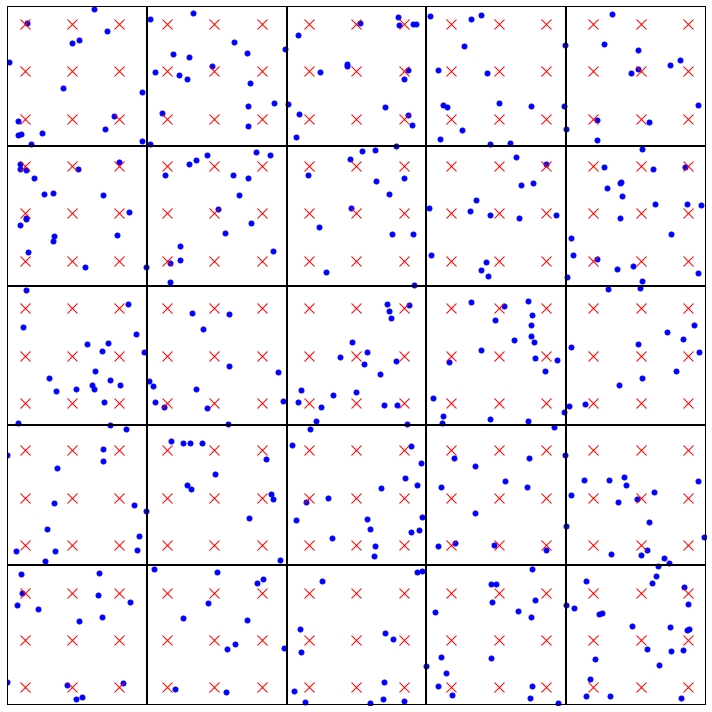

In [174]:

blocks = np.full((5, 5), np.nan)
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 10))
for x in range(6):
    ax.axhline(x, lw=2, color='k', zorder=5)
    ax.axvline(x, lw=2, color='k', zorder=5)
    
blocks = np.full((5, 5), np.nan)
ax.imshow(blocks, interpolation='none', extent=[0, 5, 0, 5], zorder=0)
    
# turn off the axis labels
ax.axis('off')

rand = np.random.RandomState(1)
samples = rand.random((2, 400)) * 5
plt.plot(*samples, '.', color='b', markersize=10)

points = np.meshgrid(np.linspace(0.125, 4.875, 15), np.linspace(0.125, 4.875, 15))
points = np.stack([x.ravel() for x in points])
plt.plot(*points, 'x', color='r', markersize=10)
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/sample_space.png',
            bbox_inches='tight', pad_inches=0)
plt.show()


Parallel

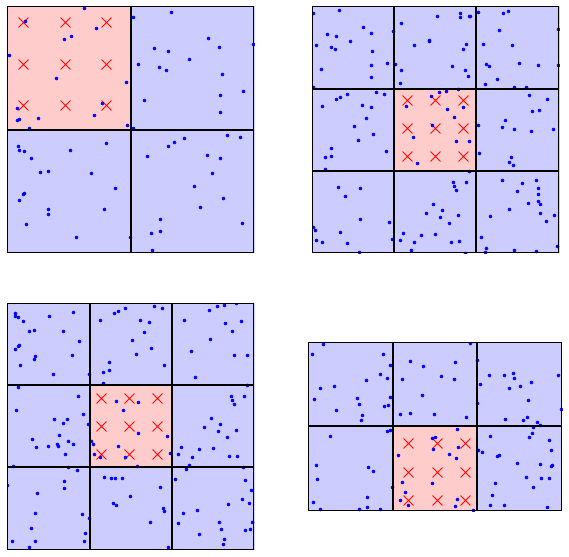

In [321]:
fig, ax = plt.subplots(2, 2, tight_layout=False, figsize=(10, 10))
my_cmap = colors.ListedColormap(['b', 'g', 'r'])
my_cmap.set_bad(color='w', alpha=0)
    
    
blocks = np.full((5, 5), np.nan)


target_blocks = [[0, 4], [2, 3], [1, 2], [3, 0]]
xi = np.arange(5)
yi = np.arange(5)

for i in range(2):
    for j in range(2):
        
        hood = np.ones((5, 5))
        target = target_blocks[i * 2 + j]
        hood[target[1], target[0]] = 2
        
        y = np.clip(target[1] - 1, 0, None), np.clip(target[1] + 2, None, 5)
        x = np.clip(target[0] - 1, 0, None), np.clip(target[0] + 2, None, 5)
        hood = hood[y[0]:y[1], x[0]:x[1]]
        offsets = 3 - np.array(hood.shape)
        
        for xl in range(hood.shape[0] + 1):
            ax[i,j].axhline(xl, lw=2, color='k', zorder=5)
        for yl in range(hood.shape[1] + 1):
            ax[i,j].axvline(yl, lw=2, color='k', zorder=5)
        ax[i,j].imshow(hood, extent=[0, hood.shape[1], 0, hood.shape[0]], cmap=my_cmap, alpha=0.2, origin='lower')
        
        point_mask = (np.floor(points[0]) == target[0]) & (np.floor(points[1]) == target[1])
        
        offset = np.array([x[0], y[0]])[:, None]
        p = points - offset
        ax[i, j].plot(*p[:, point_mask], 'x', color='r', markersize=10)
        
        
        sample_mask = (np.floor(samples[0]) >= (target[0] - 1))
        sample_mask &= (np.floor(samples[0]) <= (target[0] + 1))
        sample_mask &= (np.floor(samples[1]) >= (target[1] - 1))
        sample_mask &= (np.floor(samples[1]) <= (target[1] + 1))
        s = samples - offset
        ax[i, j].plot(*s[:, sample_mask], '.', color='b', markersize=5)
        
        ax[i, j].axis('off')
        
#         target = target_blocks[i * 2 + j]
#         blocks *= np.nan
#         point_mask = (np.floor(points[0]) == target[0]) & (np.floor(points[1]) == target[1])
# #         ax[i, j].plot(*points[:, point_mask], 'x', color='r', markersize=10)
        

        
#         hood[1 - offsets[1], 1-offsets[0]] = 2

#         for x in range(hood.shape[1] + 1):
#             ax[i,j].axhline(x, lw=2, color='k', zorder=5)
#         for y in range(hood.shape[0] + 1):
#             ax[i,j].axvline(x, lw=2, color='k', zorder=5)
            
#         ax[i, j].imshow(blocks, interpolation='none', extent=[0, hood.shape[0], 0, hood.shape[1]], zorder=0, origin='lower', alpha=0.2)
#         # turn off the axis labels
#         ax[i, j].axis('off')
        
#         sample_mask = (np.floor(samples[0]) >= (target[0] - 1))
#         sample_mask &= (np.floor(samples[0]) <= (target[0] + 1))
#         sample_mask &= (np.floor(samples[1]) >= (target[1] - 1))
#         sample_mask &= (np.floor(samples[1]) <= (target[1] + 1))
#         ax[i, j].plot(*samples[:, sample_mask], '.', color='b', markersize=5)
        

#         ax[i, j].imshow(hood, interpolation='none', cmap=my_cmap, extent=[0, 5, 0, 5], zorder=0, alpha=0.3, origin='lower')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/parallel_blocks.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()
    



Serial reduction

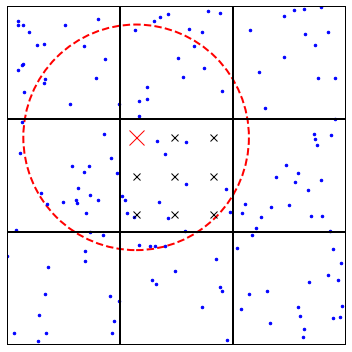

In [288]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5, 5))
my_cmap = colors.ListedColormap(['b', 'g', 'r'])
my_cmap.set_bad(color='w', alpha=0)
    
blocks = np.full((3, 3), np.nan)
target = [1, 2]
sample_mask = (np.floor(samples[0]) >= (target[0] - 1))
sample_mask &= (np.floor(samples[0]) <= (target[0] + 1))
sample_mask &= (np.floor(samples[1]) >= (target[1] - 1))
sample_mask &= (np.floor(samples[1]) <= (target[1] + 1))
target_samples = samples[:, sample_mask] - np.array(target)[:, None] + 1

target_point_mask = (np.floor(points[0]) == target[0]) & (np.floor(points[1]) == target[1])
target_points = points[:, target_point_mask] - np.array(target)[:, None] + 1

point = target_points[:, 6]
other_points = np.arange(9)
other_points = other_points != 6
other_points = target_points[:, other_points]
window = plt.Circle((point[0], point[1]), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax.add_patch(window)

ax.plot(*target_samples, '.', color='b', markersize=5)
ax.plot(*other_points, 'x', color='k', markersize=7)
ax.plot(*point, 'x', color='r', markersize=15)

blocks = np.full((3, 3), np.nan)
for x in range(4):
    ax.axhline(x, lw=2, color='k', zorder=5)
    ax.axvline(x, lw=2, color='k', zorder=5)
ax.imshow(blocks, interpolation='none', extent=[0, 3, 0, 3], zorder=0, origin='lower')
ax.axis('off')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/serial_points.png',
            bbox_inches='tight', pad_inches=0)
plt.show()



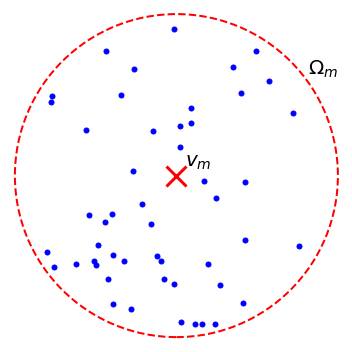

In [333]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5, 5))

window_mask = np.hypot(target_samples[0] - point[0], target_samples[1] - point[1]) <= 1
window_samples = target_samples[:, window_mask]
ax.plot(*window_samples, '.', markersize=10, color='b')
ax.plot(*point, 'x', markersize=20, color='r', markeredgewidth=3)
plt.axis("off")
plt.xlim(point[0] - 1.1, point[0] + 1.1)
plt.ylim(point[1] - 1.1, point[1] + 1.1)

window = plt.Circle((point[0], point[1]), radius=1.05, color='r', fill=False, linestyle='--', lw=2)
ax.add_patch(window)
ax.annotate(r"$v_m$", (1.20, 1.90), fontsize=20)
ax.annotate(r"$\Omega_m$", (2, 2.5), fontsize=20)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/point_fit.png',
            bbox_inches='tight', pad_inches=0)
plt.show()

Edges and uncertainty in fit

1-D example

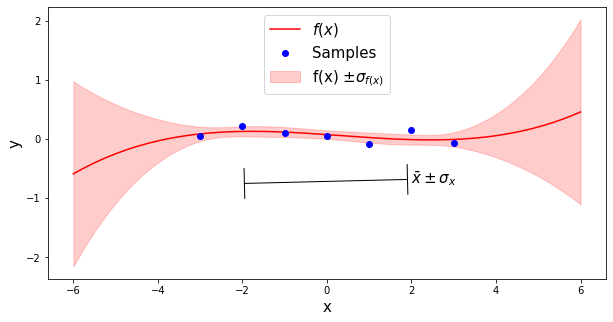

In [401]:
# sample data:
x = np.arange(7) - 3
rand = np.random.RandomState(0)
y = rand.random(7) - 0.5

# y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0, -3.0])

order = 3  # degree of polynomial
p, C_p = np.polyfit(x, y, order, cov=True)  # C_z is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(-6, 6, 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal
sig_x = np.std(x)  # Standard deviation in sample coordinates

# Do the plotting:
fg, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.set_title("Fit for Polynomial (degree {}) with $\pm1\sigma$-interval".format(n))
ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.2, color='r', label=r'f(x) $\pm \sigma_{f(x)}$')
ax.plot(t, yi, color='r', label=r'$f(x)$')
ax.plot(x, y, 'bo', label='Samples')
ax.annotate(r'$\bar{x} \pm \sigma_x$', xy=(-2, -0.75), xytext=(2,-0.75), ha='left', \
            arrowprops={'arrowstyle':'|-|'}, fontsize=15)

ax.axis('tight')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15, loc='upper center')

fg.canvas.draw()
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/distribution_error_1d.png',
            bbox_inches='tight', pad_inches=0)
plt.show()

2-D Example

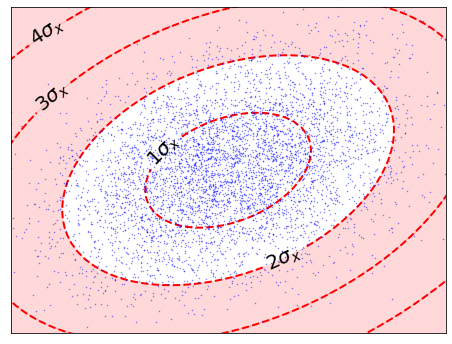

In [447]:
center = np.zeros(2)
threshold = 1.0

cov = np.array([[1.0, 0.25], [0.25, 0.5]])
# cov = np.array([[1.0, 0.0], [0.0, 1.0]])
cov /= np.linalg.det(cov)
rand = np.random.RandomState(5)
coordinates = rand.multivariate_normal(center, cov, 5000).T


x, y = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
covariance = coordinate_covariance(coordinates)

xy = np.stack([x.ravel(), y.ravel()])


# sigma = np.sqrt(calculate_distribution_variance(xy, center, cov))

sigma = np.sqrt(distribution_variances(xy, mean=center, covariance=covariance))


# g = multivariate_gaussian(covariance, xy)
# plt.contour(x, y, g.reshape(x.shape), levels=3)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.contourf(x, y, sigma.reshape(x.shape), colors=(['white'] * 2) + (['red'] * 5),
             alpha=0.15, levels=np.arange(7))

ax.plot(*coordinates, '.', markersize=1, color='blue', alpha=0.5)

sigma_plot = ax.contour(x, y, sigma.reshape(x.shape), colors=['red'],
                        linestyles='dashed', levels=np.arange(7),
                        linewidths=2)


# plt.colorbar(sigma_plot)


ax.set_ylim(-3, 3)
ax.set_xlim(-4, 4)
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.clabel(sigma_plot, fmt='%i$\sigma_x$', colors='black', fontsize=20)
# ax.set_title('Edge rejection using a threshold of 2$\sigma$')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/distribution_error_2d.png',
            bbox_inches='tight', pad_inches=-0.1)
plt.show()

/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal


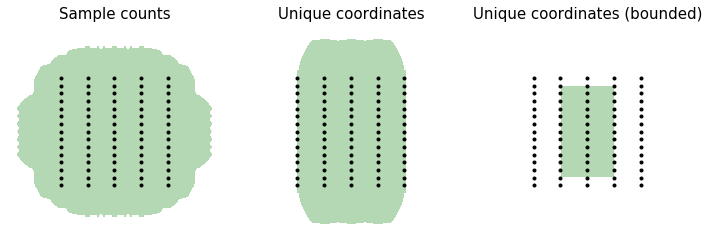

In [605]:
from sofia_redux.toolkit.resampling.resample_utils import (
    check_orders_with_counts, check_orders_without_bounds, check_orders_with_bounds)
import numpy as np
from sklearn.neighbors import BallTree

my_cmap = colors.ListedColormap(['g', 'b', 'r'])

x, y = np.meshgrid(np.linspace(0, 4, 201), np.linspace(0, 4, 201))
points = np.stack([x.ravel(), y.ravel()])

xs, ys = np.meshgrid(np.linspace(1, 3, 5), np.linspace(1, 3, 15))
samples = np.stack([xs.ravel(), ys.ravel()])

r = BallTree(samples.T)
inds = r.query_radius(points.T, 1.01)
counts = np.array([ind.size for ind in inds], dtype=float)

keep = counts > 9
p = np.zeros(x.shape, dtype=int)
p[keep.reshape(x.shape)] = 1

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))
ax[0].plot(*samples, '.', color='k')
# window = plt.Circle((0.9, 0.9), radius=1.0, color='r', fill=False, linestyle='--', lw=2)
# ax.add_patch(window)

grid = np.zeros(x.shape)
grid_counts = counts.reshape(x.shape).astype(float)
grid_counts[grid_counts < 9] = np.nan
grid_counts[grid_counts >= 9] = 1
ax[0].imshow(grid_counts, extent=[0, x.max(), 0, y.max()], cmap=my_cmap, alpha=0.3)

orders = np.full(2, 2)

extrap_counts = np.empty(x.size, dtype=float)
for i, ind in enumerate(inds):
    if ind.size == 0:
        extrap_counts[i] = 0
        continue
    c = check_orders_without_bounds(orders, samples[:, ind], required=True)
    if c[0] == -1:
        extrap_counts[i] = 0
    else:
        extrap_counts[i] = c[0]

extrap_counts[extrap_counts == 0] = np.nan
ax[1].plot(*samples, '.', color='k')
ax[1].imshow(extrap_counts.reshape(x.shape), alpha=0.3, extent=[0, x.max(), 0, y.max()], cmap=my_cmap)

bounded_counts = np.empty(x.size, dtype=float)
for i, ind in enumerate(inds):
    if ind.size == 0:
        extrap_counts[i] = 0
        continue
    c = check_orders_with_bounds(orders, samples[:, ind], points[:, i], required=True)
    if c[0] == -1:
        bounded_counts[i] = 0
    else:
        bounded_counts[i] = c[0]

bounded_counts[bounded_counts == 0] = np.nan
ax[2].plot(*samples, '.', color='k')
ax[2].imshow(bounded_counts.reshape(x.shape), alpha=0.3, extent=[0, x.max(), 0, y.max()], cmap=my_cmap)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title("Sample counts", fontsize=15)
ax[1].set_title("Unique coordinates", fontsize=15)
ax[2].set_title("Unique coordinates (bounded)", fontsize=15)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/order_check.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()


Error weighting

-0.2682421555390426
[ 1.4140662  -0.10933683]


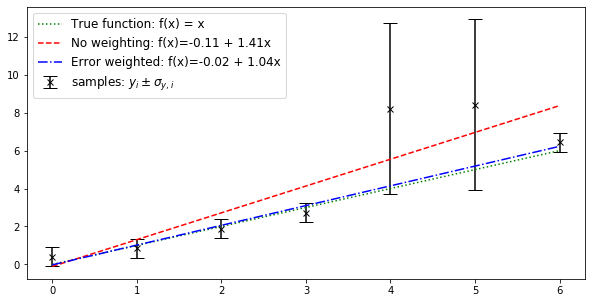

In [678]:
x = np.arange(7)
rand = np.random.RandomState(1)
y = np.arange(x.size)
noise = rand.normal(loc=0, scale=0.25, size=x.size)
noise[4:6] += 4
print(noise[3])

y = y + noise

sigma0 = np.full(x.size, 0.5)
weights0 = 1 / sigma0

sigma = sigma0.copy()
sigma[4:6] *= 9
weights = 1 / sigma

# plt.plot(x, y + noise, 'x')
c0 = np.polyfit(x, y, 1, rcond=None, full=False, w=weights0)
fit0 = np.poly1d(c0)(x)
print(c0)

c = np.polyfit(x, y, 1, rcond=None, full=False, w=weights)
fit = np.poly1d(c)(x)

plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=sigma, marker='x', capsize=7, linestyle='None', color='k', label=r'samples: $y_i \pm \sigma_{y,i}$')
plt.plot(x, x, color='g', label="True function: f(x) = x", linestyle='dotted')
plt.plot(x, fit0, linestyle='--', color='r', label="No weighting: f(x)=%.2f + %.2fx" % (c0[1], c0[0]))
plt.plot(x, fit, linestyle='-.', color='b', label="Error weighted: f(x)=%.2f + %.2fx" % (c[1], c[0]))
plt.legend(fontsize=12)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/error_weighting.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()



Standard distance weighting

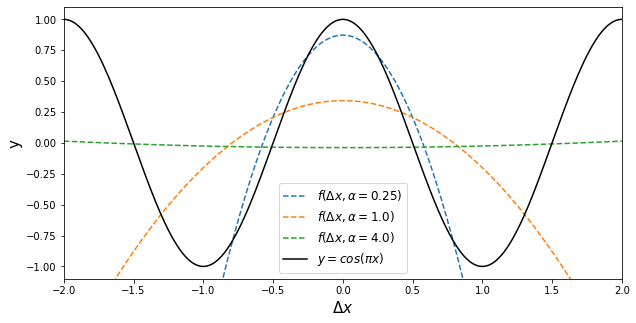

In [183]:
x = np.linspace(-2, 2, 512)
y = np.cos(x * np.pi)
plt.figure(figsize=(10, 5))

alphas = [0.25, 1.0, 4.0]
for alpha in alphas:
    w = np.exp(-(x ** 2) / alpha)
    c = np.polyfit(x, y, 2, w=np.sqrt(w))
    fit = np.poly1d(c)(x)
    plt.plot(x, fit, linestyle='--', label=r"$f(\Delta x, \alpha=%s)$" % alpha)

plt.ylim(-1.1, 1.1)
plt.xlim(-2, 2)
plt.plot(x, y, color='k', label=r'$y=cos(\pi x)$')
plt.legend(fontsize=12)
plt.xlabel(r"$\Delta x$", fontsize=15)
plt.ylabel("y", fontsize=15)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/standard_distance_weighting.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

Adaptive smoothing - initial test reduction

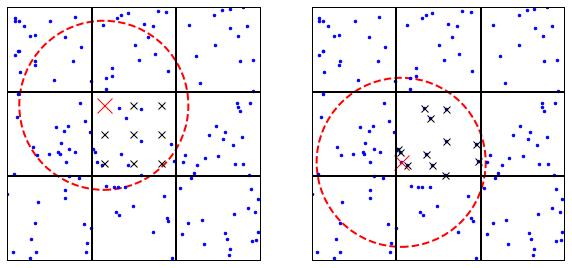

In [739]:
fig, ax = plt.subplots(1, 2, tight_layout=False, figsize=(10, 5))
my_cmap = colors.ListedColormap(['b', 'g', 'r'])
my_cmap.set_bad(color='w', alpha=0)
    
points = np.meshgrid(np.linspace(0.125, 4.875, 15), np.linspace(0.125, 4.875, 15))
points = np.stack([x.ravel() for x in points])
rand = np.random.RandomState(1)
samples = rand.random((2, 400)) * 5
    
blocks = np.full((3, 3), np.nan)
target = [1, 2]
sample_mask = (np.floor(samples[0]) >= (target[0] - 1))
sample_mask &= (np.floor(samples[0]) <= (target[0] + 1))
sample_mask &= (np.floor(samples[1]) >= (target[1] - 1))
sample_mask &= (np.floor(samples[1]) <= (target[1] + 1))
target_samples = samples[:, sample_mask] - np.array(target)[:, None] + 1


target_point_mask = (np.floor(points[0]) == target[0]) & (np.floor(points[1]) == target[1])
target_points = points[:, target_point_mask] - np.array(target)[:, None] + 1

point = target_points[:, 6]
other_points = np.arange(9)
other_points = other_points != 6

other_points = target_points[:, other_points]
window = plt.Circle((point[0], point[1]), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax[0].add_patch(window)

ax[0].plot(*target_samples, '.', color='b', markersize=5)
ax[1].plot(*target_samples, '.', color='b', markersize=5)
ax[0].plot(*other_points, 'x', color='k', markersize=7)
ax[0].plot(*point, 'x', color='r', markersize=15)


new_points_mask = (np.floor(target_samples[0]) == 1) & (np.floor(target_samples[1]) == 1)
new_points = target_samples[:, new_points_mask].copy()
new_point = new_points[:, -1].copy()
new_points = new_points[:, :-1].copy()
ax[1].plot(*new_point, 'x', color='r', markersize=15)
ax[1].plot(*new_points, 'x', color='k', markersize=7)
new_window = plt.Circle((new_point[0], new_point[1]), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax[1].add_patch(new_window)


blocks = np.full((3, 3), np.nan)
for x in range(4):
    ax[0].axhline(x, lw=2, color='k', zorder=5)
    ax[0].axvline(x, lw=2, color='k', zorder=5)
    ax[1].axhline(x, lw=2, color='k', zorder=5)
    ax[1].axvline(x, lw=2, color='k', zorder=5)
ax[0].imshow(blocks, interpolation='none', extent=[0, 3, 0, 3], zorder=0, origin='lower')
ax[0].axis('off')
ax[1].imshow(blocks, interpolation='none', extent=[0, 3, 0, 3], zorder=0, origin='lower')
ax[1].axis('off')

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/adaptive_test_reduction.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()


Adaptive kernels - shaped and scaled

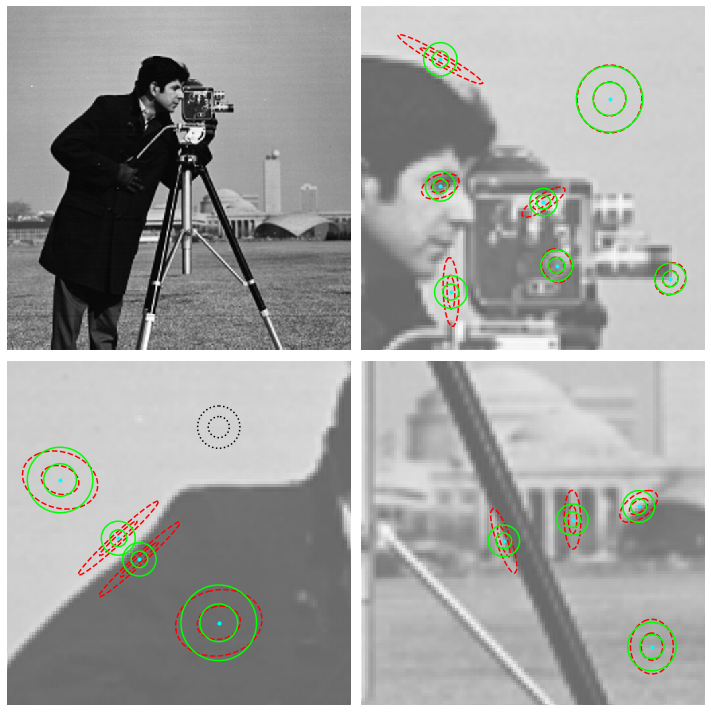

In [197]:
from skimage import data as image_data
from astropy.stats import gaussian_fwhm_to_sigma
import numpy as np
from sofia_redux.toolkit.resampling.resample import Resample
from sofia_redux.toolkit.resampling.resample_utils import relative_density
from sofia_redux.toolkit.resampling.resample_utils import shaped_adaptive_weight_matrices
from sofia_redux.toolkit.resampling.resample_utils import scaled_adaptive_weight_matrices
from sofia_redux.toolkit.resampling.resample_utils import distribution_variances
import matplotlib.pyplot as plt

%matplotlib inline

# image = hubble_deep_field().sum(axis=2).astype(float)
image = image_data.camera()
image = image.astype(float)
image -= image.min()
image /= image.max()

# ycut = np.array([360, 460])
# xcut = np.array([70, 170])

# image = image[ycut[0]:ycut[1], xcut[0]:xcut[1]].copy()

y, x = np.mgrid[:image.shape[0], :image.shape[1]]
coordinates = np.stack([c.ravel() for c in [x, y]])
error = np.std(image[:100, :150]) * 1.5 # Blank area (1.5 good)

r = Resample(coordinates, image.ravel(), error=error, order=2, window=12)

fwhm = 2.5  # 2.5 good
sigma_x = fwhm * gaussian_fwhm_to_sigma
nyquist = np.pi / np.sqrt(2 * np.log(2))
test_sigma = np.full(2, sigma_x * nyquist)
test_alpha = 2 * test_sigma ** 2
yout, xout = np.arange(image.shape[0]), np.arange(image.shape[1])

fit, err, counts, weight, distance_weights, rchi2, gradient_mscp, distribution_offset_variance = r(
    xout, yout, smoothing=test_alpha,
    get_error=True, get_counts=True, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=True,
    get_offset_variance=True, jobs=-1)

# fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 5))
# ax[0].imshow(image, cmap='gray')
# ax[1].imshow(fit)


rho = relative_density(test_sigma, counts.ravel(), distance_weights.ravel()).reshape(x.shape)
# ax[2].imshow(np.sqrt(rchi2))

deriv = gradient_mscp.reshape((x.size, 2, 2))

gmat = shaped_adaptive_weight_matrices(
    test_sigma, rchi2.ravel(), deriv,
    density=rho.ravel(),
    variance_offsets=distribution_offset_variance.ravel())

gmat0 = scaled_adaptive_weight_matrices(
    test_sigma, rchi2.ravel())

gflat = gmat.copy()
g0flat = gmat0.copy()
gmat = gmat.reshape((fit.shape[0], fit.shape[1], 2, 2))
gg = np.zeros((gmat0.shape[0], 2, 2))
gg[:, np.arange(2), np.arange(2)] = gmat0[:, 0, np.arange(2)]
gmat0 = gg
gmat0 = gmat0.reshape((fit.shape[0], fit.shape[1], 2, 2))

center = np.array([59, 19]).astype(float) # x, y

g = gmat[int(center[1]), int(center[0])]

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(10, 10))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].axis('off')

ax[0, 1].imshow(image, cmap='gray', alpha=0.6)
ax[0, 1].set_xlim(220, 350)
ax[0, 1].set_ylim(185, 55)
samples = [
    [294, 153],  # Face area
    [250, 75],
    [314, 90],
    [254, 163],
    [250, 123],
    [337, 158],
    #[298, 120],
    [289, 129]
]
ax[0, 1].axis('off')
for sample in samples:
    g = np.linalg.pinv(gmat[sample[1], sample[0]])
    g0 = np.linalg.pinv(gmat0[sample[1], sample[0]])
    center = np.array(sample, dtype=float)
    sigma = distribution_variances(coordinates, mean=center, covariance=g).reshape(x.shape)
    sigma0 = distribution_variances(coordinates, mean=center, covariance=g0).reshape(x.shape)
    ax[0, 1].contour(x, y, np.sqrt(sigma), levels=[1, 2], colors='r', linestyles='dashed')
    ax[0, 1].contour(x, y, np.sqrt(sigma0), levels=[1, 2], colors='lime', linestyles='solid')
    ax[0, 1].plot(*sample, '.', color='cyan')


ax[1, 0].imshow(image, cmap='gray', alpha=0.6)
ax[1, 0].set_xlim(70, 200)
ax[1, 0].set_ylim(215, 85)
samples = [
    [90, 130], # Shoulder area
    [112, 152],
    [120, 160],
    [150, 184]
]
ax[1, 0].axis('off')
for sample in samples:
    g = np.linalg.pinv(gmat[sample[1], sample[0]])
    g0 = np.linalg.pinv(gmat0[sample[1], sample[0]])
    center = np.array(sample, dtype=float)
    sigma = distribution_variances(coordinates, mean=center, covariance=g).reshape(x.shape)
    sigma0 = distribution_variances(coordinates, mean=center, covariance=g0).reshape(x.shape)
    ax[1, 0].contour(x, y, np.sqrt(sigma), levels=[1, 2], colors='r', linestyles='dashed')
    ax[1, 0].contour(x, y, np.sqrt(sigma0), levels=[1, 2], colors='lime', linestyles='solid')
    ax[1, 0].plot(*sample, '.', color='cyan')
    
ref_center = np.array([150, 110], dtype=float)
ref_g = np.diag(test_alpha)
ref_sigma = distribution_variances(coordinates, mean=ref_center, covariance=ref_g).reshape(x.shape)
ax[1, 0].contour(x, y, np.sqrt(ref_sigma), levels=[1, 2], colors='k', linestyles='dotted')


ax[1, 1].imshow(image, cmap='gray', alpha=0.6)
ax[1, 1].set_xlim(270, 400)
ax[1, 1].set_ylim(400, 270)
samples = [
    [350, 330], # Texture
    [375, 325],
    [324, 338],
    [380, 378]
]
ax[1, 1].axis('off')
for sample in samples:
    g = np.linalg.pinv(gmat[sample[1], sample[0]])
    g0 = np.linalg.pinv(gmat0[sample[1], sample[0]])
    center = np.array(sample, dtype=float)
    sigma = distribution_variances(coordinates, mean=center, covariance=g).reshape(x.shape)
    sigma0 = distribution_variances(coordinates, mean=center, covariance=g0).reshape(x.shape)
    ax[1, 1].contour(x, y, np.sqrt(sigma), levels=[1, 2], colors='r', linestyles='dashed')
    ax[1, 1].contour(x, y, np.sqrt(sigma0), levels=[1, 2], colors='lime', linestyles='solid')
    ax[1, 1].plot(*sample, '.', color='cyan')
    
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/adaptive_kernels.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()
    


Rchi2 -> 1

/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Probability Density')

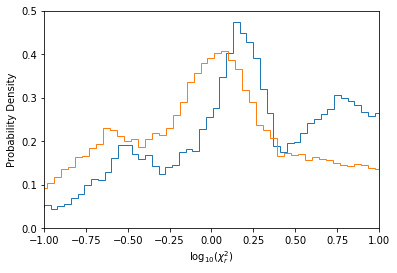

In [202]:
fit, err, counts, weight, distance_weights, rchi2, gradient_mscp, distribution_offset_variance = r(
    xout, yout, smoothing=test_alpha,
    get_error=True, get_counts=True, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=True,
    get_offset_variance=True, jobs=-1)

fit, err, counts, weight, distance_weights, rchi2, gradient_mscp, distribution_offset_variance = r(
    xout, yout, smoothing=test_alpha,
    get_error=True, get_counts=True, get_weights=True,
    get_distance_weights=True, get_rchi2=True, get_cross_derivatives=True,
    get_offset_variance=True, jobs=-1)

fit_s, rchi2_s = r(
    xout, yout, smoothing=sigma_x, adaptive_threshold=1.0,
    get_rchi2=True, jobs=-1)

plt.hist(np.log10(rchi2.ravel()), bins=100, histtype='step', density=True) 
plt.hist(np.log10(rchi2_s.ravel()), bins=100, histtype='step', density=True)
plt.xlim(-1, 1)
plt.ylim(0, 0.5)
plt.xlabel(r"$\log_{10}(\chi_r^2)$")
plt.ylabel("Probability Density")


Stretch Correction

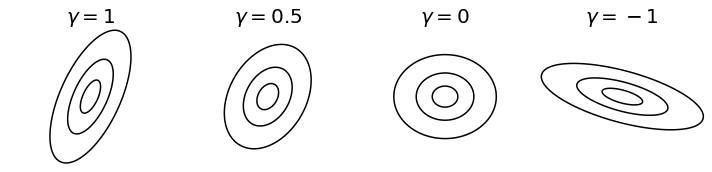

In [262]:
g = np.array([[1, 1.2], [1.2, 4]], dtype=float)
g /= np.sqrt(np.linalg.det(g))
xg, yg = np.meshgrid(np.linspace(-7, 7, 256), np.linspace(-7, 7, 256))
coordinates = np.stack([c.ravel() for c in [xg, yg]])
center = np.median(coordinates, axis=1)


u, s, v = np.linalg.svd(g)

fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 2.5))
# for i in range(2):
#     for j in range(2):
#         ax[i, j].set_xlim(-6.5, 6.5)
#         ax[i, j].set_ylim(-6.5, 6.5)
#         ax[i, j].axis('off')

for i in range(4):
    ax[i].set_xlim(-6.5, 6.5)
    ax[i].set_ylim(-6.5, 6.5)
    ax[i].axis('off')


g_p1 = u @ np.diag(s ** 1.0) @ v
sigma = distribution_variances(coordinates, mean=center, covariance=g_p1).reshape(xg.shape) ** 0.5
ax[0].contour(xg, yg, np.sqrt(sigma), levels=[1, 1.5, 2], colors='k', linestyles='solid')
ax[0].set_title(r"$\gamma=1$", fontsize=20)

g_h = u @ np.diag(s ** 0.5) @ v
sigma = distribution_variances(coordinates, mean=center, covariance=g_h).reshape(xg.shape) ** 0.5
ax[1].contour(xg, yg, np.sqrt(sigma), levels=[1, 1.5, 2], colors='k', linestyles='solid')
ax[1].set_title(r"$\gamma=0.5$", fontsize=20)

g_0 = u @ np.diag(s ** 0.0) @ v
sigma = distribution_variances(coordinates, mean=center, covariance=g_0).reshape(xg.shape) ** 0.5
ax[2].contour(xg, yg, np.sqrt(sigma), levels=[1, 1.5, 2], colors='k', linestyles='solid')
ax[2].set_title(r"$\gamma=0$", fontsize=20)

g_m1 = u @ np.diag(s ** -1.0) @ v
sigma = distribution_variances(coordinates, mean=center, covariance=g_m1).reshape(xg.shape) ** 0.5
ax[3].contour(xg, yg, np.sqrt(sigma), levels=[1, 1.5, 2], colors='k', linestyles='solid')
ax[3].set_title(r"$\gamma=-1$", fontsize=20)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/stretch_correction.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()


Stretch function (Gamma correction)

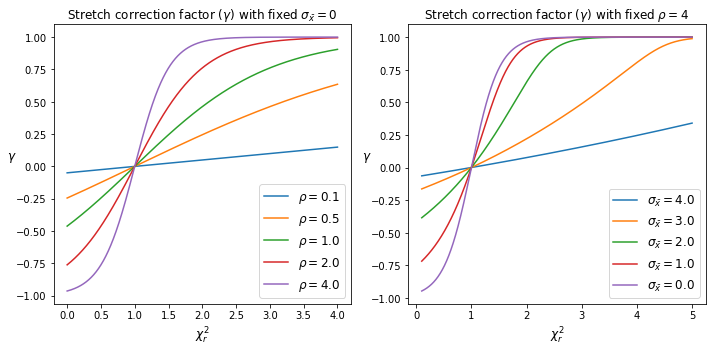

In [332]:
from sofia_redux.toolkit.resampling.resample_utils import stretch_correction

rchi2 = np.linspace(0, 4, 1000)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
my_colors = ['C' + str(i) for i in np.arange(5)]

for i, density in enumerate([0.1, 0.5, 1, 2, 4]):
   gamma_correction = stretch_correction(rchi2, density, variance_offset=0)
   ax[0].plot(rchi2, gamma_correction, color=my_colors[i], label=r"$\rho=%.1f$" % density)
   ax[0].set_xlabel(r"$\chi_r^2$", fontsize=12)
   ax[0].set_ylabel(r"$\gamma$", fontsize=12, rotation=0)
   ax[0].set_title(r"Stretch correction factor ($\gamma$) with fixed $\sigma_{\bar{x}} = 0$", fontsize=12)
 
ax[0].legend(loc='lower right', fontsize=12)

density = 4
rchi2 = np.linspace(0.1, 5, 1000)
for i, sigma in enumerate([4, 3, 2, 1, 0]):
   gamma_correction = stretch_correction(rchi2, density, variance_offset=sigma ** 2)
   ax[1].plot(rchi2, gamma_correction, color=my_colors[i], label=r"$\sigma_{\bar{x}}=%.1f$" % sigma)
   ax[1].set_xlabel(r"$\chi_r^2$", fontsize=12)
   #ax[1].set_xscale('log')
   ax[1].set_ylabel(r"$\gamma$", fontsize=12, rotation=0)
   ax[1].set_title(r"Stretch correction factor ($\gamma$) with fixed $\rho = %s$" % density, fontsize=12)
   
ax[1].legend(loc='lower right', fontsize=12)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/sigmoid_function.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()

Relative Density

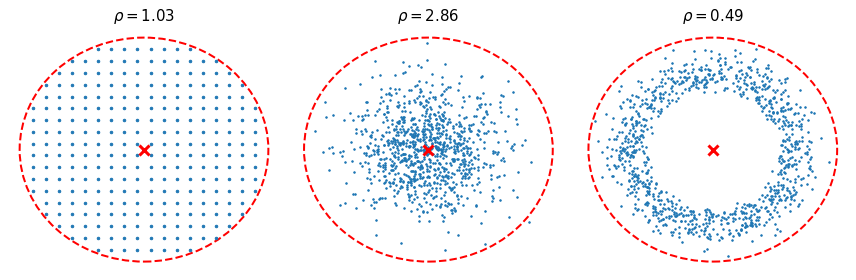

In [424]:
from sofia_redux.toolkit.resampling.tests.test_resample_utils.test_relative_density import uniform_spheroid_coordinates
from sofia_redux.toolkit.resampling.resample_utils import relative_density, calculate_distance_weights


c, r, sigma, alpha = uniform_spheroid_coordinates(2, 20, 0.3)
center = np.zeros(2)
weight_sum = np.sum(calculate_distance_weights(c, center, alpha))
density = relative_density(sigma, r.size, weight_sum)

fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))

ax[0].plot(*c, '.', markersize=5)
window = plt.Circle((0, 0), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax[0].add_patch(window)
ax[0].set_xlim(-1.1, 1.1)
ax[0].set_ylim(-1.1, 1.1)
ax[0].axis('off')
ax[0].plot(0, 0, 'x', color='r', markersize=10, markeredgewidth=3)
ax[0].set_title(r"$\rho=%.2f$" % density, fontsize=15)

rand = np.random.RandomState(0)
c_cluster = rand.normal(loc=0, scale=0.3, size=(2, 1000))
weight_sum = np.sum(calculate_distance_weights(c_cluster, center, alpha))
density = relative_density(sigma, c_cluster.shape[1], weight_sum)

window = plt.Circle((0, 0), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax[1].plot(*c_cluster, '.', markersize=3)
ax[1].add_patch(window)
ax[1].set_xlim(-1.1, 1.1)
ax[1].set_ylim(-1.1, 1.1)
ax[1].axis('off')
ax[1].plot(0, 0, 'x', color='r', markersize=10, markeredgewidth=3)
ax[1].set_title(r"$\rho=%.2f$" % density, fontsize=15)


xy = rand.normal(loc=0, scale=3, size=(2, 1000))
norm = np.linalg.norm(xy.T, axis=1)
c_depressed = (xy / 10 + xy / norm[None, :]) / 2
r = np.hypot(*c_depressed)
c_depressed = c_depressed[:, r <= 1]


weight_sum = np.sum(calculate_distance_weights(c_depressed, center, alpha))
density = relative_density(sigma, c_depressed.shape[1], weight_sum)

window = plt.Circle((0, 0), radius=1, color='r', fill=False, linestyle='--', lw=2)
ax[2].plot(*c_depressed, '.', markersize=3)
ax[2].add_patch(window)
ax[2].set_xlim(-1.1, 1.1)
ax[2].set_ylim(-1.1, 1.1)
ax[2].axis('off')
ax[2].plot(0, 0, 'x', color='r', markersize=10, markeredgewidth=3)
ax[2].set_title(r"$\rho=%.2f$" % density, fontsize=15)

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/relative_density.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()



Fixed adaptive dimensions

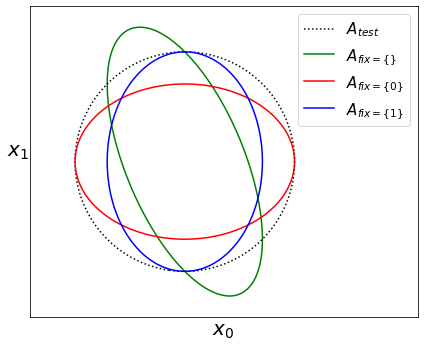

0.12500000000000008
0.25
[0.12500000000000003, 0.12500000000000003]


In [530]:
from sofia_redux.toolkit.resampling.resample_utils import shaped_adaptive_weight_matrix

# gradient_mscp = np.array([[1.5, 0.5], [0.5, 0.5]], dtype=float)
gradient_mscp = np.array([[3, 1], [1, 1]], dtype=float)
gradient_mscp /= np.sqrt(np.linalg.det(gradient_mscp))
xg, yg = np.meshgrid(np.linspace(-4, 4, 256), np.linspace(-4, 4, 256))
coordinates = np.stack([c.ravel() for c in [xg, yg]])
center = np.median(coordinates, axis=1)

sigma = np.full(2, 0.5)
alpha = 2 * sigma ** 2
rchi2 = 4.0

fixed = np.full(2, False)

A_test = np.diag(alpha)
det_A_test = np.linalg.det(A_test)

A_inv = shaped_adaptive_weight_matrix(sigma, rchi2, gradient_mscp, density=100, variance_offset=0.0,
                                      fixed=fixed)
A = np.linalg.pinv(A_inv)
det_A = np.linalg.det(A)
err = distribution_variances(coordinates, mean=center, covariance=A).reshape(xg.shape) ** 0.5

err_test = distribution_variances(coordinates, mean=center, covariance=A_test).reshape(xg.shape) ** 0.5

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 9))


ax.contour(xg, yg, err, levels=[2], colors='green', linestyles='solid')
ax.contour(xg, yg, err_test, levels=[2], colors='k', linestyles='dotted')
ax.set_xlim(-2, 3)
ax.set_ylim(-2, 2)

colors = ['red', 'blue']
linestyles = ['solid', 'solid']

dets = []

for i in range(2):
    fixed.fill(False)
    fixed[i] = True
    A_inv = shaped_adaptive_weight_matrix(sigma, rchi2, gradient_mscp, density=100, variance_offset=0.0,
                                          fixed=fixed)
    A = np.linalg.pinv(A_inv)
    err = distribution_variances(coordinates, mean=center, covariance=A).reshape(xg.shape) ** 0.5
    ax.contour(xg, yg, err, levels=[2], colors=colors[i], linestyles=linestyles[i])
    dets.append(np.linalg.det(A))

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$x_0$", fontsize=20)
ax.set_ylabel(r"$x_1\,\,\,\,$ ", fontsize=20, rotation=0)

ax.plot([], [], color='k', linestyle='dotted', label=r"$A_{test}$")
ax.plot([], [], color='green', linestyle='solid', label=r"$A_{fix=\{\}}$")
ax.plot([], [], color='red', linestyle='solid', label=r"$A_{fix=\{0\}}$")
ax.plot([], [], color='blue', linestyle='solid', label=r"$A_{fix=\{1\}}$")

ax.legend(fontsize=15)
    
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fix_adaptive.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()

print(det_A)
print(det_A_test)
print(dets)



